In [1]:
# Import all packages necessary
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

In [2]:
dataSources = ["spotify_albums.csv","spotify_artists.csv","spotify_tracks.csv"]
featuresExtracted = ["low_level_audio_features.csv","lyrics_features.csv"]

In [3]:
spotifyAlbumsDF = pd.read_csv(dataSources[0], index_col=0)
spotifyArtistsDF = pd.read_csv(dataSources[1], index_col=0)
spotifyTracksDF = pd.read_csv(dataSources[2], index_col=0)

lowLevelAudioFeaturesDF = pd.read_csv(featuresExtracted[0], index_col=0)
lyricsFeaturesDF = pd.read_csv(featuresExtracted[1], index_col=0)

In [4]:
# Renaming columns
spotifyAlbumsDF.rename(columns={"name":"track_name", "id":"album_id", "available_markets":"album_available_markets", "release_date":"album_release_date", "total_tracks":"album_total_tracks"}, inplace=True)
spotifyArtistsDF.rename(columns={"id":"artist_id", "name":"artist_name", "genres":"artist_genres"}, inplace=True)
spotifyTracksDF.rename(columns={"id":"track_id"}, inplace=True)

# Adding column with number of available markets
n_available_markets = []
for n in spotifyAlbumsDF["album_available_markets"]:
    n_available_markets.append(len(n[1:-1].replace("'","").replace(" ","").split(",")))
spotifyAlbumsDF["n_available_markets_album"] = n_available_markets

# Adding column with number of featured artists
n_artists_featured = []
for n in spotifyTracksDF["artists_id"]:
    n_artists_featured.append(len(n[1:-1].replace("'","").replace(" ","").split(",")))
spotifyTracksDF["n_artists_featured"] = n_artists_featured

In [5]:
# Album release date has been excluded at the moment - Check later (?)
# Might be interesting to check whether year/month has an impact on popularity
spotifyAlbumsDF_columns = ["album_type", "artist_id", "n_available_markets_album", "album_id", "album_total_tracks", "track_id"]
spotifyAlbumsDF = spotifyAlbumsDF.loc[:, spotifyAlbumsDF_columns]
spotifyAlbumsDF.columns

Index(['album_type', 'artist_id', 'n_available_markets_album', 'album_id',
       'album_total_tracks', 'track_id'],
      dtype='object')

In [6]:
spotifyArtistsDF_columns = ["artist_popularity", "followers", "artist_genres", "artist_id", "track_id"]
spotifyArtistsDF = spotifyArtistsDF.loc[:, spotifyArtistsDF_columns]
spotifyArtistsDF.columns

Index(['artist_popularity', 'followers', 'artist_genres', 'artist_id',
       'track_id'],
      dtype='object')

In [7]:
# Playlist variable has been excluded at the moment - Check later (?)
spotifyTracksDF_remove_columns = ["analysis_url", "artists_id", "available_markets", "disc_number", "href", "name", "playlist", "preview_url", "track_href", "track_name_prev", "track_number", "uri", "type", "lyrics"]
spotifyTracksDF = spotifyTracksDF[spotifyTracksDF.columns.difference(spotifyTracksDF_remove_columns)]
spotifyTracksDF.columns

Index(['acousticness', 'album_id', 'country', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'n_artists_featured', 'popularity', 'speechiness', 'tempo',
       'time_signature', 'track_id', 'valence'],
      dtype='object')

In [25]:
dataSourcesDF = spotifyAlbumsDF.merge(spotifyArtistsDF).merge(spotifyTracksDF)
featuresExtracted = lowLevelAudioFeaturesDF.merge(lyricsFeaturesDF)
spotifyDF = dataSourcesDF.merge(featuresExtracted).set_index("track_id")

In [31]:
spotifyDF = spotifyDF.drop(["artist_id", "album_id"], axis=1)
# Requires further treatment with encoders
spotifyDF = spotifyDF.drop(["artist_genres", "album_type", "country"], axis=1)

In [18]:
# Excluding Quasi-Constant Features
# Remove feature column where approximately 99% of the values are similar
spotifyDFFeatures = spotifyDF.loc[:, spotifyDF.columns!="popularity"]
quasi_constant_filter = VarianceThreshold(threshold=0.01)
quasi_constant_filter.fit(spotifyDFFeatures)
quasi_constant_columns = [column for column in spotifyDFFeatures.columns
                    if column not in spotifyDFFeatures.columns[quasi_constant_filter.get_support()]]

print(f"Quasi-Constant Features: {quasi_constant_columns}")
spotifyDF = spotifyDF[spotifyDF.columns.difference(quasi_constant_columns)]

Quasi-Constant Features: ['MEL_110', 'MEL_111', 'MEL_112', 'MEL_113', 'MEL_114', 'MEL_115', 'MEL_116', 'MEL_117', 'MEL_118', 'MEL_119', 'MEL_120', 'MEL_121', 'MEL_122', 'MEL_123', 'MEL_124', 'MEL_125', 'MEL_126', 'MEL_127', 'MEL_128', 'Tonnetz_1', 'Tonnetz_2', 'Tonnetz_3', 'Tonnetz_4', 'Tonnetz_5', 'Tonnetz_6', 'ZCR']


In [19]:
# Excluding highly correlated features
spotifyDFFeatures = spotifyDF.loc[:, spotifyDF.columns!="popularity"]
correlation_matrix = spotifyDFFeatures.corr()

correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f"Highly-correlated Features: {correlated_features}")
spotifyDF = spotifyDF[spotifyDF.columns.difference(correlated_features)]

Highly-correlated Features: {'MEL_109', 'MEL_101', 'MEL_102', 'MEL_97', 'MEL_107', 'MEL_85', 'MEL_95', 'MEL_88', 'MEL_98', 'MEL_83', 'MEL_87', 'spectral_rollOff_max', 'MEL_104', 'MEL_103', 'MEL_105', 'MEL_99', 'vocabulary_wealth', 'MEL_108', 'MEL_96', 'MEL_106'}


<AxesSubplot:>

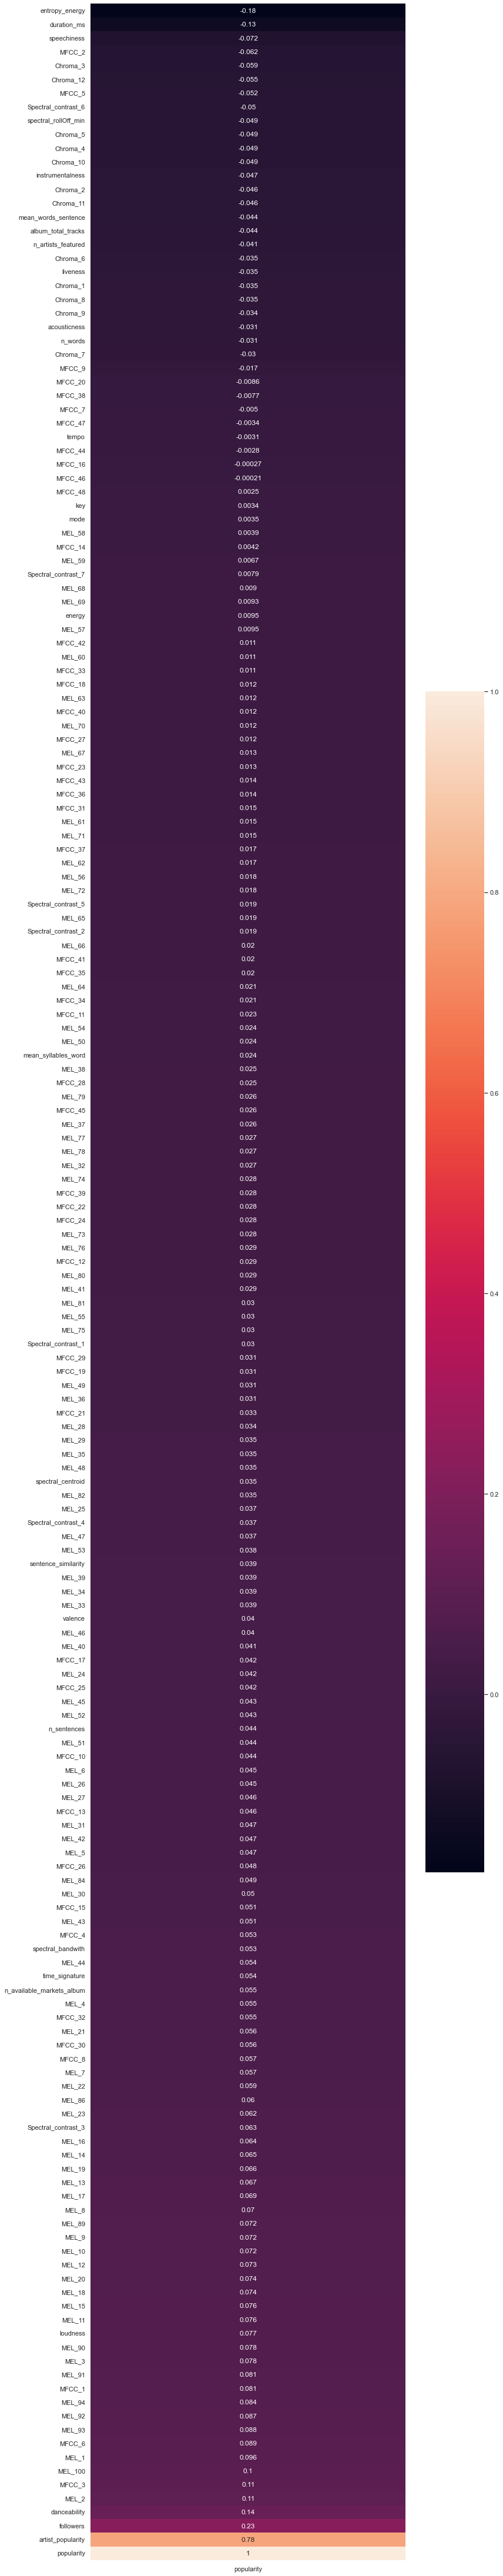

In [20]:
corr = spotifyDF.corr()
popularity_corr = corr[["popularity"]]
popularity_corr = popularity_corr.sort_values(by=["popularity"])

fig, ax = plt.subplots(figsize=(12, 80))
sns.heatmap(popularity_corr, annot=True)

In [21]:
spotifyDF.to_csv("spotify_df.csv")

In [22]:
spotifyDF

,Chroma_1,Chroma_10,Chroma_11,Chroma_12,Chroma_2,Chroma_3,Chroma_4,Chroma_5,Chroma_6,Chroma_7,...,n_words,popularity,sentence_similarity,spectral_bandwith,spectral_centroid,spectral_rollOff_min,speechiness,tempo,time_signature,valence
track_id,,,,,,,,,,,,,,,,,,,,,
3jJKj4QTK3v18ZSwpk7AcV,0.376483,0.379921,0.318157,0.284994,0.752080,0.865362,0.572321,0.496404,0.537695,0.404953,...,-1,4.0,-1.000000,3061.877754,2977.125152,113.415981,0.0669,126.060,4.0,0.4480
6BHHQJCjGtAxl9eZVTo20K,0.509783,0.511560,0.434550,0.468981,0.551524,0.552275,0.483992,0.481380,0.471250,0.532589,...,166,16.0,0.038710,3353.956934,2650.739646,247.906834,0.0465,149.699,4.0,0.1470
5v6RFQXo46SblxEYhzUkqX,0.550430,0.512631,0.545466,0.673597,0.451178,0.476112,0.636571,0.759030,0.631666,0.548984,...,370,31.0,0.001350,1967.859440,2239.418711,282.598291,0.0385,89.956,4.0,0.7480
45RBx5WYi0JFx6p69RDeyx,0.282862,0.977504,0.621494,0.353732,0.205969,0.236540,0.308125,0.273479,0.227245,0.229700,...,344,36.0,0.016611,2729.973083,2422.919247,124.924245,0.0584,123.264,3.0,0.4230
0eeQWYlmkHvqwBBNCOQXd8,0.466103,0.253506,0.302710,0.457228,0.374660,0.411710,0.482297,0.418646,0.357148,0.377267,...,370,32.0,0.001350,1358.915527,1280.667669,322.148052,0.0488,131.112,4.0,0.0355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32OuR1BddFnEBRQlH9hfLl,0.469100,0.640705,0.668057,0.539438,0.503971,0.585510,0.707814,0.576626,0.462420,0.478962,...,129,45.0,0.046346,3509.212646,3594.284495,166.173995,0.1150,112.930,4.0,0.9310
3CZY7jD1Zf30zIdbwS5212,0.619890,0.508830,0.548676,0.603225,0.631809,0.589460,0.566707,0.542238,0.569915,0.648333,...,299,40.0,0.023695,3752.975044,5101.268578,234.181917,0.0533,123.971,4.0,0.8890
7GOBsKucPG5Bh8qzStmrQ6,0.432420,0.534517,0.460831,0.475414,0.452662,0.548236,0.457733,0.361404,0.370681,0.532864,...,719,46.0,0.056178,3322.791736,2311.367633,164.557338,0.0312,114.950,4.0,0.9710
